<a href="https://colab.research.google.com/github/RRG314/topological-adam/blob/paper/topological_adam_physics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install topological-adam

100%|██████████| 9.91M/9.91M [00:00<00:00, 125MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 34.7MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 128MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.60MB/s]


Using device: cpu

=== Mode: stable_plasma ===
Epoch 1/5 | TrainLoss=0.3429 | TestAcc=94.86%
Epoch 2/5 | TrainLoss=0.1301 | TestAcc=96.76%
Epoch 3/5 | TrainLoss=0.0884 | TestAcc=97.24%
Epoch 4/5 | TrainLoss=0.0639 | TestAcc=97.71%
Epoch 5/5 | TrainLoss=0.0472 | TestAcc=97.87%

=== Mode: superconducting ===
Epoch 1/5 | TrainLoss=0.3426 | TestAcc=95.42%
Epoch 2/5 | TrainLoss=0.1291 | TestAcc=97.04%
Epoch 3/5 | TrainLoss=0.0857 | TestAcc=97.27%
Epoch 4/5 | TrainLoss=0.0657 | TestAcc=97.69%
Epoch 5/5 | TrainLoss=0.0486 | TestAcc=97.68%

=== Mode: viscous_fluid ===
Epoch 1/5 | TrainLoss=0.3478 | TestAcc=95.00%
Epoch 2/5 | TrainLoss=0.1346 | TestAcc=96.53%
Epoch 3/5 | TrainLoss=0.0872 | TestAcc=97.47%
Epoch 4/5 | TrainLoss=0.0627 | TestAcc=97.84%
Epoch 5/5 | TrainLoss=0.0468 | TestAcc=97.68%

=== Mode: quantum_osc ===
Epoch 1/5 | TrainLoss=0.3528 | TestAcc=94.72%
Epoch 2/5 | TrainLoss=0.1312 | TestAcc=96.55%
Epoch 3/5 | TrainLoss=0.0863 | TestAcc=97.02%
Epoch 4/5 | TrainLoss=0.0627 | TestAcc

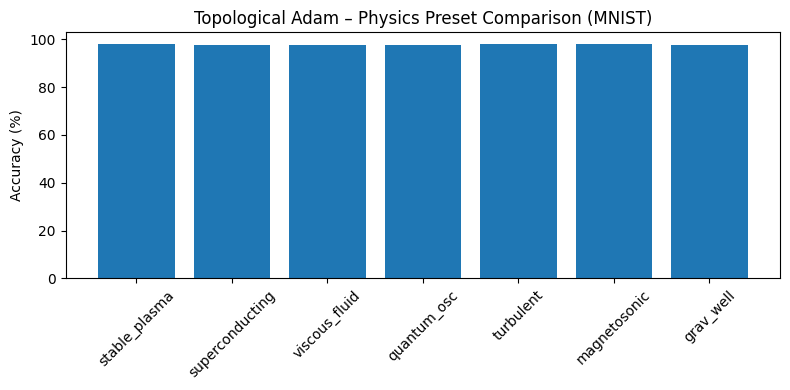

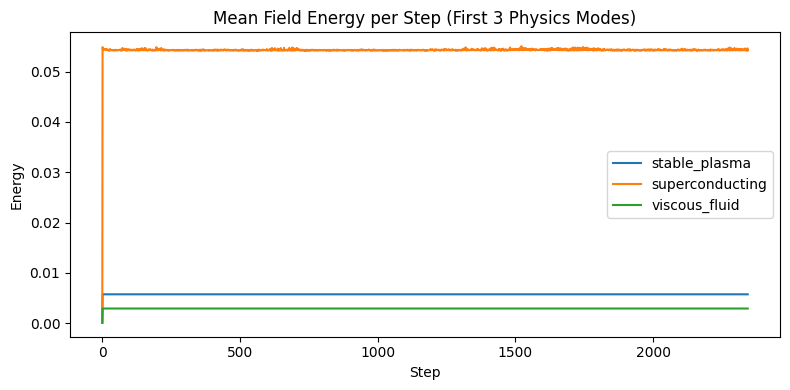

In [ ]:
# ==============================================================
#  Topological Adam – Physics-Mode Benchmark Development Script
#  (No Pro package needed; uses your installed topological-adam)
# ==============================================================
!pip install torch torchvision matplotlib topological-adam -q

import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt, time, math
from topological_adam import TopologicalAdam

# --------------------------------------------------------------
#  Define the physics-style parameter presets
# --------------------------------------------------------------
presets = {
    "stable_plasma":  dict(eta=0.02, mu0=0.5,  w_topo=0.15, target_energy=1e-3),
    "superconducting":dict(eta=0.05, mu0=0.1,  w_topo=0.20, target_energy=1e-2),
    "viscous_fluid":  dict(eta=0.01, mu0=1.0,  w_topo=0.10, target_energy=5e-4),
    "quantum_osc":    dict(eta=0.03, mu0=0.3,  w_topo=0.18, target_energy=2e-3),
    "turbulent":      dict(eta=0.06, mu0=0.25, w_topo=0.25, target_energy=1e-2),
    "magnetosonic":   dict(eta=0.04, mu0=0.40, w_topo=0.12, target_energy=8e-4),
    "grav_well":      dict(eta=0.03, mu0=0.6,  w_topo=0.15, target_energy=1e-3)
}

# --------------------------------------------------------------
#  Simple MLP model for MNIST
# --------------------------------------------------------------
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --------------------------------------------------------------
#  Data loaders
# --------------------------------------------------------------
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, transform=transforms.ToTensor()),
    batch_size=1000)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --------------------------------------------------------------
#  Training and evaluation helpers
# --------------------------------------------------------------
def train(model, optimizer, loader):
    model.train()
    total_loss, energy_trace = 0, []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        loss = F.cross_entropy(model(X), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if hasattr(optimizer, "energy"):
            energy_trace.append(optimizer.energy())
    return total_loss / len(loader), energy_trace

def test(model, loader):
    model.eval()
    correct, loss = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss += F.cross_entropy(out, y, reduction="sum").item()
            pred = out.argmax(1)
            correct += pred.eq(y).sum().item()
    loss /= len(loader.dataset)
    acc = 100.0 * correct / len(loader.dataset)
    return loss, acc

# --------------------------------------------------------------
#  Benchmark loop
# --------------------------------------------------------------
epochs = 5
results = {}
for mode, params in presets.items():
    print(f"\n=== Mode: {mode} ===")
    model = Net().to(device)
    optimizer = TopologicalAdam(model.parameters(), lr=1e-3, **params)
    start = time.time()
    energy_hist = []
    for ep in range(1, epochs + 1):
        l, e_trace = train(model, optimizer, train_loader)
        tl, acc = test(model, test_loader)
        energy_hist += e_trace
        print(f"Epoch {ep}/{epochs} | TrainLoss={l:.4f} | TestAcc={acc:.2f}%")
    results[mode] = dict(loss=tl, acc=acc, time=time.time() - start,
                         energy=energy_hist)

# --------------------------------------------------------------
#  Visualize accuracy comparison
# --------------------------------------------------------------
modes = list(results.keys())
accs = [results[m]["acc"] for m in modes]
plt.figure(figsize=(8,4))
plt.bar(modes, accs)
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("Topological Adam – Physics Preset Comparison (MNIST)")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
#  Energy trace visualization for first few modes
# --------------------------------------------------------------
plt.figure(figsize=(8,4))
for m in list(results.keys())[:3]:
    plt.plot(results[m]["energy"], label=m)
plt.title("Mean Field Energy per Step (First 3 Physics Modes)")
plt.xlabel("Step")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()